# Sweep conveniences

This notebook describes __how to use__ convenience methods that the __sweep__ framework provides in order to define and perform experiments.

In the notebook, we will go through the convenience functions, discuss their use, present some examples. We will also cover how sweep framework integrates with QCoDeS.

Note that the internal organization of the framework and description of its core components is a subject of a different notebook.

# Recap of motivation for sweep

It is worth mentioning a short summary of why the sweep framework emerged.

Nowadays, code has become a tool for experimentalists. They write lines of code that define experiments, perform measurements, analyze data, etc. With the number and variety of measurements, researchers want to be able to define new experiments and modify existing ones in a swift and fast way.

Ease of experiment code modification is limited when one uses frameworks as QCoDeS because of the boilerplate code that the framework requires you to write. Nevertheless, one should not forget that the explicitness of a lower-level framework is key to its flexibility.

In this situation, the sweep framework finds its place for experiments that are not complex but frequently performed. The sweep framework balances between hiding as much boilerplate as possible and being flexible enough to justify its existence.

Those who are familiar with `Loop` from `QCoDeS` may recall how limiting it was, and how difficult it was to extend it. With the reference to this experience, the sweep framework does __not__ claim that it is as flexible as pure Python code.

# What is a sweep object?

Using the convenience methods of the sweep framework which are described in this notebook, we will be creating sweep objects. But is a sweep object?

A sweep object is:
* a way to encapsulate flow control and data acquisition
* an interable in python language sense
* an object that at each iteration returns a dictionary of name-value pairs of data

This description of the sweep object __solely__ repesents how users should percieve it when using the convenience functions. This description is not intended to cover "how it works under the hood" (as methoned above, this is a subject for a different notebook).

In terms of code usage within python, the definition of the sweep object results in the following python-pseudo-code representation:
```python
sweep_object = <... sweep voltage V 
                        from 1 to 2 with step 0.2,
                    measure at each point
                        current I 
                        and temperature T 
               ...>

for data_point in sweep_object:
    print(data_point)
    # prints smth like for every data point:
    # {'V': 1.4, 'I': 4.23, 'T': 0.3}
```

The use of the sweep object is very simple, right? Just iterate over it using `for` loop, and consume the data points in any way you want, for example, store them in a file.

But how does one define a sweep object in a:
* easy way?
* readable way?
* clean way?
* adjustible way?

That's what the convenience functions are for.

# sweep convenience

Let's start with the `sweep` function. We are going to build up the understanding of the power of this function step by step.

In [1]:
from pytopo.sweep import sweep

The simplest use case for a sweep when some variable needs to a predefined list of values, for example, one wants to sweep a voltage on an instrument from `a` V to `b` V with the step of `s` V.

## setter convenience

While sweeping, the voltage will be __set__ to the values specified in the list. This is how we approach the notion of a `setter` function.

A `setter` function is a normal python function that has an input argument, does not return anything, and it's intention is to perform logic that is required to set something to a particular value. In the simplest case, this function will just set some attribute of some object. In a more complicated case, it could perform some calculation, wait until an isntrument is ready for the next value to be set, or any other logic that may be required.

One can easily make any python function a `setter` with the use of the `setter` decorator. The setter decorator requires arguments. (Can a `setter` function set more than one value? - Yes, but keep reading.) The arguments should be tuples. Each tuple has to contain at least 2 elements: first one represents the name associated with the value that is being set, and the second one represents the units of that value.

In [3]:
from pytopo.sweep import setter

Let's define a dummy instrument as a class with an attribute, and a setter function that sets that attribute to a given value, and prints a message.

In [18]:
class VoltageSource:
    """
    A dummy voltage source instrument.
    """
    def __init__(self):
        self.voltage = 0


v_source = VoltageSource()


@setter(('gate_voltage', 'V'))
def set_voltage(voltage):
    v_source.voltage = voltage
    print(f"[set_voltage]: Set voltage source to {voltage}")

Let's try to use the setter function:

In [19]:
set_voltage(2.5)

# If the setter function does not work, this line will raise an exception
assert 2.5 == v_source.voltage
print(f'The voltage source voltage is indeed {v_source.voltage} :)')

[set_voltage]: Set voltage source to 2.5
The voltage source voltage is indeed 2.5 :)


This works, right? Let's get back to the `sweep` then.

## sweep convenience: basic use

Having a `setter` function defined, we can use the `sweep` convenience to call that setter function for a list of values, like this:

In [20]:
so = sweep(set_voltage, [1, 2, 3])

That's it!

This sweep object will iterate over the given list of values (`[1, 2, 3]`), call `set_voltage` with each of these values, and return a dictionary containing the value that has just been set under the key `gate_voltage` as specified in the `setter` decorator for the `set_voltage` function.

In order to prove it, let's execute the following code which is a very dumb implementation of "consumer" of sweep objects. In this case, this dummy "consumer" validates what the sweep object returns, and prints it out. See for yourself:

In [23]:
print('started sweeping!')

# "consume" the sweep object with a `for` loop
for data_point in so:
    
    # validate what the sweep_object yields
    assert isinstance(data_point, dict)
    assert 'gate_voltage' in data_point.keys()
    
    # print the data
    print(f'sweeping... now at data point: {data_point}')

print('done sweeping!')

started sweeping!
[set_voltage]: Set voltage source to 1
sweeping... now at data point: {'gate_voltage': 1}
[set_voltage]: Set voltage source to 2
sweeping... now at data point: {'gate_voltage': 2}
[set_voltage]: Set voltage source to 3
sweeping... now at data point: {'gate_voltage': 3}
done sweeping!


In [3]:
from qcodes import Parameter
from qcodes.dataset.plotting import plot_by_id

from pytopo.sweep import sweep, measure, do_experiment

In [5]:
x = Parameter("x", set_cmd=None, get_cmd=None)
y = Parameter("y", set_cmd=None, get_cmd=None)
m = Parameter("m", get_cmd=lambda: x.get()**2 + y.get())

In [7]:
sweep_object = \
    sweep(x, [0, 1, 2])(
        sweep(y, [0, 1, 2])(
            measure(m), 
        )
    )

setup = [lambda: None]
cleanup = [lambda: None]

In [10]:
experiment_result = do_experiment(
    "sweep_demo/no_sample",
    sweep_object, 
    setup, 
    cleanup
)

Starting experimental run with id: 2


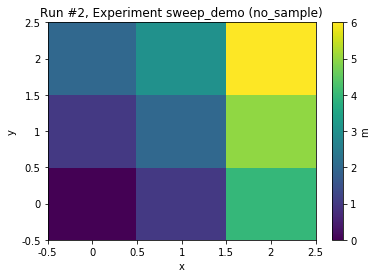

In [11]:
experiment_result.plot()

In [12]:
experiment_result["m"]

{'x': array([0, 0, 0, 1, 1, 1, 2, 2, 2]),
 'y': array([0, 1, 2, 0, 1, 2, 0, 1, 2]),
 'm': array([0, 1, 2, 1, 2, 3, 4, 5, 6])}